In [2]:
# Run this cell to import pyspark and to define start_spark() and stop_spark()

import findspark

findspark.init()

import getpass
import pandas
import pyspark
import random
import re

from IPython.display import display, HTML
from pyspark import SparkContext
from pyspark.sql import SparkSession


# Functions used below

def username():
    """Get username with any domain information removed.
    """

    return re.sub('@.*', '', getpass.getuser())


def dict_to_html(d):
    """Convert a Python dictionary into a two column table for display.
    """

    html = []

    html.append(f'<table width="100%" style="width:100%; font-family: monospace;">')
    for k, v in d.items():
        html.append(f'<tr><td style="text-align:left;">{k}</td><td>{v}</td></tr>')
    html.append(f'</table>')

    return ''.join(html)


def show_as_html(df, n=20):
    """Leverage existing pandas jupyter integration to show a spark dataframe as html.
    
    Args:
        n (int): number of rows to show (default: 20)
    """

    display(df.limit(n).toPandas())

    
def display_spark():
    """Display the status of the active Spark session if one is currently running.
    """
    
    if 'spark' in globals() and 'sc' in globals():

        name = sc.getConf().get("spark.app.name")
        
        html = [
            f'<p><b>Spark</b></p>',
            f'<p>The spark session is <b><span style="color:green">active</span></b>, look for <code>{name}</code> under the running applications section in the Spark UI.</p>',
            f'<ul>',
            f'<li><a href="http://mathmadslinux2p.canterbury.ac.nz:8080/" target="_blank">Spark UI</a></li>',
            f'<li><a href="{sc.uiWebUrl}" target="_blank">Spark Application UI</a></li>',
            f'</ul>',
            f'<p><b>Config</b></p>',
            dict_to_html(dict(sc.getConf().getAll())),
            f'<p><b>Notes</b></p>',
            f'<ul>',
            f'<li>The spark session <code>spark</code> and spark context <code>sc</code> global variables have been defined by <code>start_spark()</code>.</li>',
            f'<li>Please run <code>stop_spark()</code> before closing the notebook or restarting the kernel or kill <code>{name}</code> by hand using the link in the Spark UI.</li>',
            f'</ul>',
        ]
        display(HTML(''.join(html)))
        
    else:
        
        html = [
            f'<p><b>Spark</b></p>',
            f'<p>The spark session is <b><span style="color:red">stopped</span></b>, confirm that <code>{username() + " (jupyter)"}</code> is under the completed applications section in the Spark UI.</p>',
            f'<ul>',
            f'<li><a href="http://mathmadslinux2p.canterbury.ac.nz:8080/" target="_blank">Spark UI</a></li>',
            f'</ul>',
        ]
        display(HTML(''.join(html)))


# Functions to start and stop spark

def start_spark(executor_instances=2, executor_cores=1, worker_memory=1, master_memory=1):
    """Start a new Spark session and define globals for SparkSession (spark) and SparkContext (sc).
    
    Args:
        executor_instances (int): number of executors (default: 2)
        executor_cores (int): number of cores per executor (default: 1)
        worker_memory (float): worker memory (default: 1)
        master_memory (float): master memory (default: 1)
    """

    global spark
    global sc

    user = username()
    
    cores = executor_instances * executor_cores
    partitions = cores * 4
    port = 4000 + random.randint(1, 999)

    spark = (
        SparkSession.builder
        .master("spark://masternode2:7077")
        .config("spark.driver.extraJavaOptions", f"-Dderby.system.home=/tmp/{user}/spark/")
        .config("spark.dynamicAllocation.enabled", "false")
        .config("spark.executor.instances", str(executor_instances))
        .config("spark.executor.cores", str(executor_cores))
        .config("spark.cores.max", str(cores))
        .config("spark.executor.memory", f"{worker_memory}g")
        .config("spark.driver.memory", f"{master_memory}g")
        .config("spark.driver.maxResultSize", "0")
        .config("spark.sql.shuffle.partitions", str(partitions))
        .config("spark.ui.port", str(port))
        .appName(user + " (jupyter)")
        .getOrCreate()
    )
    sc = SparkContext.getOrCreate()
    
    display_spark()

    
def stop_spark():
    """Stop the active Spark session and delete globals for SparkSession (spark) and SparkContext (sc).
    """

    global spark
    global sc

    if 'spark' in globals() and 'sc' in globals():

        spark.stop()

        del spark
        del sc

    display_spark()


# Make css changes to improve spark output readability

html = [
    '<style>',
    'pre { white-space: pre !important; }',
    'table.dataframe td { white-space: nowrap !important; }',
    'table.dataframe thead th:first-child, table.dataframe tbody th { display: none; }',
    '</style>',
]
display(HTML(''.join(html)))

In [3]:
# Run this cell to start a spark session in this notebook

start_spark(executor_instances=4, executor_cores=2, worker_memory=4, master_memory=4)

spark.dynamicAllocation.enabled,false
spark.executor.instances,4
spark.app.startTime,1714120916808
spark.driver.memory,4g
spark.executor.memory,4g
spark.master,spark://masternode2:7077
spark.executor.id,driver
spark.executor.cores,2
spark.driver.host,mathmadslinux2p.canterbury.ac.nz
spark.app.id,app-20240426204157-0114
spark.sql.shuffle.partitions,32


In [4]:
# Write your imports and code here or insert cells below

from pyspark.sql import functions as F
from pyspark.sql.types import *
from pyspark.sql.functions import col,substring,trim, udf,min, max, countDistinct
import math
from pyspark.sql.window import Window
import pandas as pd
import matplotlib.pyplot as plt

### Processing ###


In [5]:
# Q2 a) Define a schema for daily
schema_daily = StructType([
    StructField("ID", StringType(), True),  # Station code as a string
    StructField("DATE", StringType(), True),  # Observation date as a date
    StructField("ELEMENT", StringType(), True),  # Element type indicator as a string
    StructField("VALUE", FloatType(), True),  # Data value for ELEMENT as a float
    StructField("MEASUREMENT_FLAG", StringType(), True),  # Measurement Flag as a string
    StructField("QUALITY_FLAG", StringType(), True),  # Quality Flag as a string
    StructField("SOURCE_FLAG", StringType(), True),  # Source Flag as a string
    # Observation time as a string since PySpark does not have a TimeType
    StructField("OBSERVATION_TIME", StringType(), True)
])

# Q2 b) Load 1000 rows of the 2023.csv.gz
df_daily = (
    spark.read
    .schema(schema_daily)
    .csv("hdfs:///data/ghcnd/daily/2023.csv.gz")
    .limit(1000)
)
df_daily.show(200)

+-----------+--------+-------+-----+----------------+------------+-----------+----------------+
|         ID|    DATE|ELEMENT|VALUE|MEASUREMENT_FLAG|QUALITY_FLAG|SOURCE_FLAG|OBSERVATION_TIME|
+-----------+--------+-------+-----+----------------+------------+-----------+----------------+
|AE000041196|20230101|   TMAX|252.0|            null|        null|          S|            null|
|AE000041196|20230101|   TMIN|149.0|            null|        null|          S|            null|
|AE000041196|20230101|   PRCP|  0.0|               D|        null|          S|            null|
|AE000041196|20230101|   TAVG|207.0|               H|        null|          S|            null|
|AEM00041194|20230101|   TMAX|255.0|            null|        null|          S|            null|
|AEM00041194|20230101|   TMIN|186.0|            null|        null|          S|            null|
|AEM00041194|20230101|   PRCP|  0.0|            null|        null|          S|            null|
|AEM00041194|20230101|   TAVG|223.0|    

In [6]:
# Q2 c)load stations
df_stations = (
    spark.read.text("hdfs:///data/ghcnd/ghcnd-stations.txt")
    .select(
        substring(col("value"), 1, 11).alias("ID"),
        substring(col("value"), 13, 8).alias("LATITUDE"),
        substring(col("value"), 22, 9).alias("LONGITUDE"),
        substring(col("value"), 32, 6).alias("ELEVATION"),
        substring(col("value"), 39, 2).alias("STATE"),
        substring(col("value"), 42, 30).alias("NAME"),
        substring(col("value"), 73, 3).alias("GSN_FLAG"),
        substring(col("value"), 77, 3).alias("HCN/CRN_FLAG"),
        substring(col("value"), 81, 5).alias("WMO_ID")
    )
)

# load states
df_states = spark.read.text("hdfs:///data/ghcnd/ghcnd-states.txt").select(
    substring(col("value"), 1, 2).alias("STATE_CODE"),
    substring(col("value"), 4, 47).alias("STATE_NAME")
)


# load countries
df_countries = spark.read.text("hdfs:///data/ghcnd/ghcnd-countries.txt").select(
    substring(col("value"), 1, 2).alias("COUNTRY_CODE"),
    substring(col("value"), 4, 47).alias("COUNTRY_NAME")
)


# load inventory
df_inventory = spark.read.text("hdfs:///data/ghcnd/ghcnd-inventory.txt").select(
    substring(col("value"), 1, 11).alias("ID"),
    substring(col("value"), 13, 8).alias("LATITUDE"),
    substring(col("value"), 22, 9).alias("LONGITUDE"),
    substring(col("value"), 32, 4).alias("ELEMENT"),
    substring(col("value"), 37, 4).alias("FIRSTYEAR"),
    substring(col("value"), 42, 4).alias("LASTYEAR")
)

# calculate the number of rows of each metadata table
num_rows_stations = df_stations.count()
num_rows_states = df_states.count()
num_rows_countries = df_countries.count()
num_rows_inventory = df_inventory.count()

# calculate the number of stations do not have a VMO_ID
num_stations_no_wmo_id = df_stations.filter(trim(col("WMO_ID")) == '').count()

print("Number of rows in stations:", num_rows_stations)
print("Number of rows in states:", num_rows_states)
print("Number of rows in countries:", num_rows_countries)
print("Number of rows in inventory:", num_rows_inventory)
print("Number of stations without a WMO ID:", num_stations_no_wmo_id)

Number of rows in stations: 125983
Number of rows in states: 74
Number of rows in countries: 219
Number of rows in inventory: 747382
Number of stations without a WMO ID: 118023


In [7]:
df_stations.show()
df_states.show()
df_countries.show()
df_inventory.show()

+-----------+--------+---------+---------+-----+--------------------+--------+------------+------+
|         ID|LATITUDE|LONGITUDE|ELEVATION|STATE|                NAME|GSN_FLAG|HCN/CRN_FLAG|WMO_ID|
+-----------+--------+---------+---------+-----+--------------------+--------+------------+------+
|ACW00011604| 17.1167| -61.7833|     10.1|     |ST JOHNS COOLIDGE...|        |            |      |
|ACW00011647| 17.1333| -61.7833|     19.2|     |ST JOHNS         ...|        |            |      |
|AE000041196| 25.3330|  55.5170|     34.0|     |SHARJAH INTER. AI...|     GSN|            | 41196|
|AEM00041194| 25.2550|  55.3640|     10.4|     |DUBAI INTL       ...|        |            | 41194|
|AEM00041217| 24.4330|  54.6510|     26.8|     |ABU DHABI INTL   ...|        |            | 41217|
|AEM00041218| 24.2620|  55.6090|    264.9|     |AL AIN INTL      ...|        |            | 41218|
|AF000040930| 35.3170|  69.0170|   3366.0|     |NORTH-SALANG     ...|     GSN|            | 40930|
|AFM000409

In [8]:
# Q3 a) Extract the two character country code and store the output as a new column
df_stations = df_stations.withColumn("COUNTRY_CODE", col("ID").substr(1, 2))
df_stations.show()

+-----------+--------+---------+---------+-----+--------------------+--------+------------+------+------------+
|         ID|LATITUDE|LONGITUDE|ELEVATION|STATE|                NAME|GSN_FLAG|HCN/CRN_FLAG|WMO_ID|COUNTRY_CODE|
+-----------+--------+---------+---------+-----+--------------------+--------+------------+------+------------+
|ACW00011604| 17.1167| -61.7833|     10.1|     |ST JOHNS COOLIDGE...|        |            |      |          AC|
|ACW00011647| 17.1333| -61.7833|     19.2|     |ST JOHNS         ...|        |            |      |          AC|
|AE000041196| 25.3330|  55.5170|     34.0|     |SHARJAH INTER. AI...|     GSN|            | 41196|          AE|
|AEM00041194| 25.2550|  55.3640|     10.4|     |DUBAI INTL       ...|        |            | 41194|          AE|
|AEM00041217| 24.4330|  54.6510|     26.8|     |ABU DHABI INTL   ...|        |            | 41217|          AE|
|AEM00041218| 24.2620|  55.6090|    264.9|     |AL AIN INTL      ...|        |            | 41218|      

In [9]:
# Q3 b) LEFT JOIN stations with countries
df_stations_with_countries = df_stations.join(df_countries,"COUNTRY_CODE", "left")
df_stations_with_countries.show()

+------------+-----------+--------+---------+---------+-----+--------------------+--------+------------+------+--------------------+
|COUNTRY_CODE|         ID|LATITUDE|LONGITUDE|ELEVATION|STATE|                NAME|GSN_FLAG|HCN/CRN_FLAG|WMO_ID|        COUNTRY_NAME|
+------------+-----------+--------+---------+---------+-----+--------------------+--------+------------+------+--------------------+
|          AC|ACW00011604| 17.1167| -61.7833|     10.1|     |ST JOHNS COOLIDGE...|        |            |      |Antigua and Barbuda |
|          AC|ACW00011647| 17.1333| -61.7833|     19.2|     |ST JOHNS         ...|        |            |      |Antigua and Barbuda |
|          AE|AE000041196| 25.3330|  55.5170|     34.0|     |SHARJAH INTER. AI...|     GSN|            | 41196|United Arab Emira...|
|          AE|AEM00041194| 25.2550|  55.3640|     10.4|     |DUBAI INTL       ...|        |            | 41194|United Arab Emira...|
|          AE|AEM00041217| 24.4330|  54.6510|     26.8|     |ABU DHAB

In [10]:
# Q3 c）LEFT JOIN stations and states
df_stations_with_states = df_stations_with_countries.join(df_states, df_stations["STATE"] == df_states["STATE_CODE"], "left")
df_stations_with_states.show()

+------------+-----------+--------+---------+---------+-----+--------------------+--------+------------+------+--------------------+----------+----------+
|COUNTRY_CODE|         ID|LATITUDE|LONGITUDE|ELEVATION|STATE|                NAME|GSN_FLAG|HCN/CRN_FLAG|WMO_ID|        COUNTRY_NAME|STATE_CODE|STATE_NAME|
+------------+-----------+--------+---------+---------+-----+--------------------+--------+------------+------+--------------------+----------+----------+
|          AC|ACW00011604| 17.1167| -61.7833|     10.1|     |ST JOHNS COOLIDGE...|        |            |      |Antigua and Barbuda |      null|      null|
|          AC|ACW00011647| 17.1333| -61.7833|     19.2|     |ST JOHNS         ...|        |            |      |Antigua and Barbuda |      null|      null|
|          AE|AE000041196| 25.3330|  55.5170|     34.0|     |SHARJAH INTER. AI...|     GSN|            | 41196|United Arab Emira...|      null|      null|
|          AE|AEM00041194| 25.2550|  55.3640|     10.4|     |DUBAI INT

In [11]:
# Q3 d) Calculate the first and last year that each station was active
df_active_years = df_inventory.groupBy('ID').agg(
    min('FIRSTYEAR').alias('FIRST_YEAR'),
    max('LASTYEAR').alias('LAST_YEAR')
)

# Calculate the number of different elements each station has collected
df_element_count = df_inventory.groupBy('ID').agg(
    countDistinct('ELEMENT').alias('NUM_ELEMENTS')
)


# Define core elements list, for example
core_elements = ['PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN']

# count the number of core elements and the number of ”other” elements
df_core_elements_count = df_inventory.filter(F.col("ELEMENT").isin(core_elements)).groupBy("ID").agg(
    F.countDistinct("ELEMENT").alias("core_elements_count")
)
df_other_elements_count = df_inventory.filter(~F.col("ELEMENT").isin(core_elements)).groupBy("ID").agg(
    F.countDistinct("ELEMENT").alias("other_elements_count")
)

#Find out how many stations collect all five core elements
df_stations_all_core = df_core_elements_count.filter(F.col("core_elements_count") == 5).count()

# Determine how many stations collect only precipitation and no other elements
df_stations_only_precip = df_inventory.groupBy("ID").agg(
    F.collect_set("ELEMENT").alias("elements_collected")
).filter(
    (F.size("elements_collected") == 1) & (F.array_contains("elements_collected", "PRCP"))
).count()

# Output the results
print("First and last year each station was active:")
df_active_years.show()

print("How many different elements each station has collected overall:")
df_element_count.show()

print("Count of core and other elements:")
df_core_elements_count.show()
df_other_elements_count.show()

print(f"Number of stations with all five core elements: {df_stations_all_core}")
print(f"Number of stations that collect only precipitation: {df_stations_only_precip}")

First and last year each station was active:
+-----------+----------+---------+
|         ID|FIRST_YEAR|LAST_YEAR|
+-----------+----------+---------+
|AGE00147719|      1888|     2024|
|ALE00100939|      1940|     2000|
|AQC00914873|      1955|     1967|
|AR000000002|      1981|     2000|
|AR000875850|      1908|     2024|
|ARM00087022|      1973|     2024|
|ARM00087480|      1965|     2024|
|ARM00087904|      2003|     2024|
|ASN00001003|      1909|     1940|
|ASN00002033|      1920|     1965|
|ASN00002042|      1932|     1993|
|ASN00003021|      1899|     1992|
|ASN00003047|      1929|     1940|
|ASN00003069|      1974|     1992|
|ASN00004031|      1949|     1983|
|ASN00004047|      1924|     1976|
|ASN00004062|      1913|     1942|
|ASN00004087|      1984|     1986|
|ASN00005004|      1915|     2022|
|ASN00006011|      1750|     2024|
+-----------+----------+---------+
only showing top 20 rows

How many different elements each station has collected overall:
+-----------+------------

In [12]:
# Q3 e) LEFT JOIN stations and your output from part (d).
stations_enriched = df_stations_with_states.join(df_active_years, "ID", "left")\
    .join(df_element_count, "ID", "left")\
    .join(df_core_elements_count, "ID", "left")\
    .join(df_other_elements_count, "ID", "left")

# show the merger dataframe structure and  partial data
stations_enriched.printSchema()
stations_enriched.show()

root
 |-- ID: string (nullable = true)
 |-- COUNTRY_CODE: string (nullable = true)
 |-- LATITUDE: string (nullable = true)
 |-- LONGITUDE: string (nullable = true)
 |-- ELEVATION: string (nullable = true)
 |-- STATE: string (nullable = true)
 |-- NAME: string (nullable = true)
 |-- GSN_FLAG: string (nullable = true)
 |-- HCN/CRN_FLAG: string (nullable = true)
 |-- WMO_ID: string (nullable = true)
 |-- COUNTRY_NAME: string (nullable = true)
 |-- STATE_CODE: string (nullable = true)
 |-- STATE_NAME: string (nullable = true)
 |-- FIRST_YEAR: string (nullable = true)
 |-- LAST_YEAR: string (nullable = true)
 |-- NUM_ELEMENTS: long (nullable = true)
 |-- core_elements_count: long (nullable = true)
 |-- other_elements_count: long (nullable = true)

+-----------+------------+--------+---------+---------+-----+--------------------+--------+------------+------+--------------------+----------+--------------+----------+---------+------------+-------------------+--------------------+
|         ID|

In [13]:
# save it to personal output directory
output_path = "hdfs:///user/dwe55/outputs/stations"

# Save it as parquet format
stations_enriched.write.mode("overwrite").parquet(output_path)

In [14]:
# Q3 f) LEFT JOIN your 1000 rows subset of daily and your output from part (e).
df_daily_joined = df_daily.join(stations_enriched,"ID","left")
df_daily_joined.show()

+-----------+--------+-------+-----+----------------+------------+-----------+----------------+------------+--------+---------+---------+-----+--------------------+--------+------------+------+------------+----------+----------+----------+---------+------------+-------------------+--------------------+
|         ID|    DATE|ELEMENT|VALUE|MEASUREMENT_FLAG|QUALITY_FLAG|SOURCE_FLAG|OBSERVATION_TIME|COUNTRY_CODE|LATITUDE|LONGITUDE|ELEVATION|STATE|                NAME|GSN_FLAG|HCN/CRN_FLAG|WMO_ID|COUNTRY_NAME|STATE_CODE|STATE_NAME|FIRST_YEAR|LAST_YEAR|NUM_ELEMENTS|core_elements_count|other_elements_count|
+-----------+--------+-------+-----+----------------+------------+-----------+----------------+------------+--------+---------+---------+-----+--------------------+--------+------------+------+------------+----------+----------+----------+---------+------------+-------------------+--------------------+
|AGE00147719|20230101|   TMIN|  1.0|            null|        null|          S|          

In [15]:
missing_stations_in_daily = df_daily_joined.filter(df_daily_joined["NAME"].isNull())

# calculate the number of stations in the daily subset that are not in the enriched stations
num_missing_stations_in_daily = missing_stations_in_daily.count()
print(f"Number of stations in the daily subset that are not in the enriched stations: {num_missing_stations_in_daily}")

Number of stations in the daily subset that are not in the enriched stations: 7


# Analysis

In [16]:
# Q1 a) calculate the stations
total_stations = stations_enriched.select("ID").distinct().count()
print(f"There are {total_stations} stations in total")

# calculate the number of stations that were active so far in 2024
active_stations_2024 = stations_enriched.filter(stations_enriched['LAST_YEAR'] == 2024).select('ID').distinct().count()
print(f"There are {active_stations_2024} stations that were active so far in 2024")

# calculate the number of stations in GSN,HCN,CRN
stations_in_GSN = stations_enriched.filter(col('GSN_FLAG') == "GSN").count()
print(f"There are {stations_in_GSN} stations in GSN ")

stations_in_HCN = stations_enriched.filter(col('HCN/CRN_FLAG') == "HCN").count()
print(f"There are {stations_in_HCN} stations in HCN ")

stations_in_CRN = stations_enriched.filter(col('HCN/CRN_FLAG') == "CRN").count()
print(f"There are {stations_in_CRN} stations in CRN ")

# calculate the number of stations that are in more than one of networks
stations_in_multiple = stations_enriched.filter((col('GSN_FLAG') == "GSN") & (col('HCN/CRN_FLAG').isin(["HCN","CRN"]))).count()
print(f"There are {stations_in_multiple} stations in multiple networks")

There are 125983 stations in total
There are 31837 stations that were active so far in 2024
There are 991 stations in GSN 
There are 1218 stations in HCN 
There are 234 stations in CRN 
There are 15 stations in multiple networks


In [17]:
# Q1 b) Count the total number of stations in each country
stations_per_country = stations_enriched.groupBy('COUNTRY_CODE').count()

# Join these counts onto countries 
countries_with_station_counts = df_countries.join(stations_per_country, 'COUNTRY_CODE')

countries_with_station_counts.show(300)

#  Count the total number of stations in each state
stations_per_state = stations_enriched.groupBy('STATE_CODE').count()

# Join these counts onto countries 
state_with_station_counts = df_states.join(stations_per_state, 'STATE_CODE')

state_with_station_counts.show(100)

+------------+--------------------+-----+
|COUNTRY_CODE|        COUNTRY_NAME|count|
+------------+--------------------+-----+
|          TI|         Tajikistan |   62|
|          BB|           Barbados |    1|
|          BG|          Bangladesh|   10|
|          CA|             Canada | 9188|
|          MX|             Mexico | 5249|
|          NI|             Nigeria|   10|
|          SW|             Sweden | 1721|
|          UG|              Uganda|    8|
|          MZ|         Mozambique |   19|
|          WQ|Wake Island [Unit...|    1|
|          GH|               Ghana|   18|
|          GM|            Germany | 1123|
|          CH|             China  |  228|
|          NH|            Vanuatu |    6|
|          TO|               Togo |   10|
|          TU|             Turkey |   59|
|          WI|     Western Sahara |    1|
|          TD|Trinidad and Tobago |    4|
|          HU|            Hungary |   10|
|          BN|              Benin |    9|
|          PC|Pitcairn Islands ...

+----------+--------------------+-----+
|STATE_CODE|          STATE_NAME|count|
+----------+--------------------+-----+
|        NT|NORTHWEST TERRITO...|  137|
|        CA|          CALIFORNIA| 3080|
|        OK|            OKLAHOMA| 1081|
|        MN|           MINNESOTA| 2199|
|        ND|        NORTH DAKOTA|  574|
|        NH|       NEW HAMPSHIRE|  471|
|        OH|                OHIO| 1397|
|        WI|           WISCONSIN| 1412|
|        MB|            MANITOBA|  731|
|        AZ|             ARIZONA| 1655|
|        FM|          MICRONESIA|   38|
|        NM|          NEW MEXICO| 2234|
|        MH|    MARSHALL ISLANDS|   21|
|        AL|ALABAMA          ...| 1101|
|        AR|            ARKANSAS|  937|
|        FL|             FLORIDA| 2142|
|        VI|      VIRGIN ISLANDS|   71|
|        NB|       NEW BRUNSWICK|  309|
|        NL|NEWFOUNDLAND AND ...|  334|
|        KS|              KANSAS| 2217|
|        KY|            KENTUCKY|  960|
|        LA|           LOUISIANA|  769|


In [18]:
# save it to personal output directory
output_path1 = "hdfs:///user/dwe55/outputs/countries"
countries_with_station_counts.write.mode("overwrite").csv(output_path1)
output_path2 = "hdfs:///user/dwe55/outputs/states"
state_with_station_counts.write.mode("overwrite").csv(output_path2)

In [19]:
# c) calculate the number of stations that are in the Southern Hemisphere
southern_hemisphere_station_count = stations_enriched.filter(col('LATITUDE') < 0).count()
print(f"There are {southern_hemisphere_station_count} number of stations in the Southern Hemisphere.")

There are 25316 number of stations in the Southern Hemisphere.


In [20]:
us_territories_stations = stations_enriched.filter(
    col("COUNTRY_NAME").like("%United States%") & ~(col("COUNTRY_CODE") == "US")
)

# Count the number of stations in the US territories
us_territories_stations_count = us_territories_stations.count()

print(f"The number of stations in the US territories（excluding US itself）: {us_territories_stations_count}")

The number of stations in the US territories（excluding US itself）: 386


In [21]:
# Q2
# define the user function
def haversine_distance(lat1, lon1, lat2, lon2):
    # Ensure that the input latitude and longitude data is converted to floating number
    lat1, lon1, lat2, lon2 = map(float, (lat1, lon1, lat2, lon2))
    
    # Radius of the Earth(km)
    R = 6371.0
    
    # Convert latitude and longitude to radians
    lat1_rad = math.radians(lat1)
    lon1_rad = math.radians(lon1)
    lat2_rad = math.radians(lat2)
    lon2_rad = math.radians(lon2)
    
    # haversine formula
    dlon = lon2_rad - lon1_rad
    dlat = lat2_rad - lat1_rad
    a = math.sin(dlat / 2)**2 + math.cos(lat1_rad) * math.cos(lat2_rad) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    
    distance = R * c
    return distance

# creat UDF
haversine_distance_udf = udf(haversine_distance, FloatType())

In [22]:
# Limit the size of the dataset,like 10 stations for testing
df_stations_subset = stations_enriched.limit(10)

# Perform a CROSS JOIN to generate a combination of each pair of stations
df_stations_cross_joined =stations_enriched .alias('a').crossJoin(stations_enriched.alias('b'))

# Calculate the distanca 
df_stations_with_distances = df_stations_cross_joined.withColumn(
    "distance",
    haversine_distance_udf(
        col("a.LATITUDE"), col("a.LONGITUDE"), col("b.LATITUDE"), col("b.LONGITUDE")
    )
)

# show the result
df_stations_with_distances.select("a.ID", "b.ID", "distance").show()

+-----------+-----------+---------+
|         ID|         ID| distance|
+-----------+-----------+---------+
|AGE00147719|AGE00147719|      0.0|
|AGE00147719|ALE00100939| 1704.037|
|AGE00147719|AQC00914873|17759.969|
|AGE00147719|AR000000002| 9494.348|
|AGE00147719|AR000875850| 9930.884|
|AGE00147719|ARM00087022|  9435.64|
|AGE00147719|ARM00087480| 9961.673|
|AGE00147719|ARM00087904|11880.663|
|AGE00147719|ASN00001003|13984.069|
|AGE00147719|ASN00002033|14337.421|
|AGE00147719|ASN00002042| 14111.16|
|AGE00147719|ASN00003021|14053.692|
|AGE00147719|ASN00003047|13889.793|
|AGE00147719|ASN00003069|13827.779|
|AGE00147719|ASN00004031| 13462.05|
|AGE00147719|ASN00004047|13629.928|
|AGE00147719|ASN00004062|13670.284|
|AGE00147719|ASN00004087|13480.294|
|AGE00147719|ASN00005004|13269.413|
|AGE00147719|ASN00006011|13354.805|
+-----------+-----------+---------+
only showing top 20 rows



In [23]:
# Q2 b) 
 
nz_stations = stations_enriched.filter(col("COUNTRY_CODE") == "NZ")

cross_joined_nz_stations = nz_stations.alias("a").crossJoin(nz_stations.alias("b"))

distances = cross_joined_nz_stations.select(
    col("a.ID").alias("id1"),
    col("a.LATITUDE").alias("latitude1"),
    col("a.LONGITUDE").alias("longitude1"),
    col("b.ID").alias("id2"),
    col("b.LATITUDE").alias("latitude2"),
    col("b.LONGITUDE").alias("longitude2"),
    haversine_distance_udf(col("a.LATITUDE"),col("a.LONGITUDE"),col("b.LATITUDE"),col("b.LONGITUDE")).alias("distances")
)

# Select the two closest stations and give the columns sliases
closest_stations = distances.filter(col("id1") != col("id2")).orderBy("distances").select(
    "id1", 
    "id2", 
    "distances"
).first()

# show the result
print(f"The two stations that closest in NZ is: {closest_stations['id1']} and {closest_stations['id2']}, distance: {closest_stations['distances']}km")

The two stations that closest in NZ is: NZ000093417 and NZM00093439, distance: 50.52902603149414km


In [24]:
print(nz_stations.count())

15


In [25]:
# save the dataset
output_path3 = "hdfs:///user/dwe55/outputs/distances"
distances.write.mode("overwrite").csv(output_path3)

In [26]:
# Load the dataset in 2023
df_2023 = spark.read.csv("hdfs:///data/ghcnd/daily/2023.csv.gz",schema=schema_daily,header=True)
# count the number of observations in 2023
num_observations_2023 = df_2023.count()
print(f"The number of observations in 2023 is: {num_observations_2023}")
# Get the number of partitions in 2023 dataset
num_partitions_2023 = df_2023.rdd.getNumPartitions()
print(f"The number of partitions in 2023 is: {num_partitions_2023}")

# Load the dataset in 2024
df_2024 = spark.read.csv("hdfs:///data/ghcnd/daily/2024.csv.gz",schema=schema_daily,header=True)
# count the number of observations in 2024
num_observations_2024 = df_2024.count()
print(f"The number of observations in 2024 is: {num_observations_2024}")
# Get the number of partitions in 2024 dataset
num_partitions_2024 = df_2024.rdd.getNumPartitions()
print(f"The number of partitions in 2024 is: {num_partitions_2024}")


The number of observations in 2023 is: 37395851
The number of partitions in 2023 is: 1
The number of observations in 2024 is: 6061826
The number of partitions in 2024 is: 1


In [27]:
# Load the dataset from 2014 to 2023
df_2014_2023 = spark.read.csv("hdfs:///data/ghcnd/daily/{2014,2015,2016,2017,2018,2019,2020,2021,2022,2023}.csv.gz",schema=schema_daily,header=True)

# count the number of observations from 2014 to 2023
total_observations = df_2014_2023.count()
print(f"The number of observations from 2014 to 2023 is: {total_observations}")

# Get the number of partitions from 2014 to 2023 dataset
num_partitions = df_2014_2023.rdd.getNumPartitions()
print(f"The number of partitions from 2014 to 2023 is: {num_partitions}")

The number of observations from 2014 to 2023 is: 369419055
The number of partitions from 2014 to 2023 is: 10


In [33]:
# d)# Evaluate the number of parallel tasks

df_all_years = spark.read.csv("hdfs:///data/ghcnd/daily/*.csv.gz",schema=schema_daily,header=True)
num_executors = spark._jsc.sc().getExecutorMemoryStatus().size()
num_cores_per_executor = int(spark.conf.get("spark.executor.cores"))
total_cores = num_executors * num_cores_per_executor
print(f"Total number of cores: {total_cores}")

# Estimate the number of parallel tasks to loaf and transform all data
num_partitions = df_all_years.rdd.getNumPartitions()
print(f"Number of partitions of data: {num_partitions}")


Total number of cores: 10
Number of partitions of data: 104


In [34]:
# Q4 a)
# Load the data
df_all_daily = spark.read.csv("hdfs:///data/ghcnd/daily/*.csv.gz",schema=schema_daily,header=True)

# Count the number of rows
num_rows = df_all_daily.count()
print(f"Number of rows in daily: {num_rows}")

Number of rows in daily: 3103953878


In [35]:
# b)

# Define the core elements
core_elements = ["PRCP", "SNOW", "SNWD", "TMAX", "TMIN"]

# Filter the dataset for core elements
df_core_elements = df_all_daily.filter(df_all_daily["ELEMENT"].isin(core_elements))

# Count observations for each core element
observations_count = df_core_elements.groupBy("ELEMENT").count()
observations_count.show()

# Find which element has the most observations
most_observations = observations_count.orderBy("count", ascending=False).first()
print(f"Element with most observations: {most_observations['ELEMENT']}")

+-------+----------+
|ELEMENT|     count|
+-------+----------+
|   SNOW| 353904305|
|   SNWD| 297846434|
|   TMIN| 454759397|
|   PRCP|1069105128|
|   TMAX| 455945931|
+-------+----------+

Element with most observations: PRCP


In [36]:
# Find stations with TMIN but not TMAX
# filter out the observation data of TMIN and TMAX respectively
tmin_observations = df_core_elements.filter(df_core_elements["ELEMENT"] == "TMIN")
tmax_observations = df_core_elements.filter(df_core_elements["ELEMENT"] == "TMAX")

# Use a left outer join to find records with TMIN but no corresponding TMAX
tmin_not_tmax = tmin_observations.join(
    tmax_observations,
    (tmin_observations["ID"] == tmax_observations["ID"]) & 
    (tmin_observations["DATE"] == tmax_observations["DATE"]),
    "left_anti"
)

# count the number
num_tmin_not_tmax = tmin_not_tmax.count()

print(f"Number of cases where a TMIN record exists but no corresponding TMAX is: {num_tmin_not_tmax}")

Number of cases where a TMIN record exists but no corresponding TMAX is: 9322844


In [37]:
# count the number of different stations
unique_stations_count = tmin_not_tmax.select("ID").distinct().count()

print(f"Number of unique stations with only TMIN but no corresponding TMAX is: {unique_stations_count}")

Number of unique stations with only TMIN but no corresponding TMAX is: 27929


In [38]:
# d)
nz_tmin_tmax = df_all_daily.filter(
    df_all_daily["ID"].startswith("NZ") & 
    df_all_daily["ELEMENT"].isin(["TMIN", "TMAX"]))


In [39]:
# save the dataset
output_path4 = "hdfs:///user/dwe55/outputs/NZ"
nz_tmin_tmax.write.mode("overwrite").csv(output_path4)

In [40]:
# count the total number
observations_count = nz_tmin_tmax.count()

# count the number of years
years = nz_tmin_tmax.withColumn('Year', F.substring('DATE', 1, 4))
unique_years = years.select('Year').distinct().count()

# print the output
print(f"Number of observations for TMIN and TMAX in New Zealand: {observations_count}")
print(f"Total number of years covered by observations is: {unique_years}")

Number of observations for TMIN and TMAX in New Zealand: 485520
Total number of years covered by observations is: 85


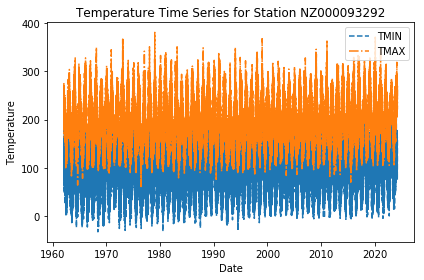

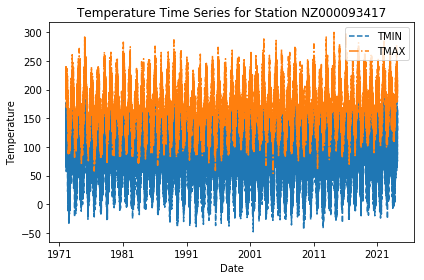

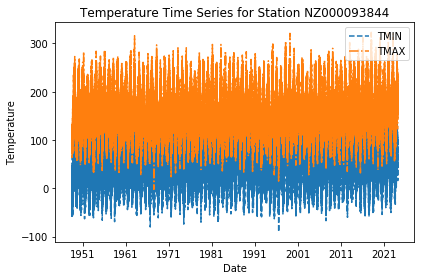

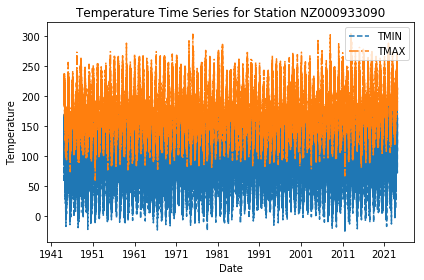

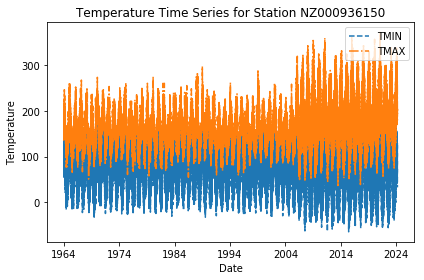

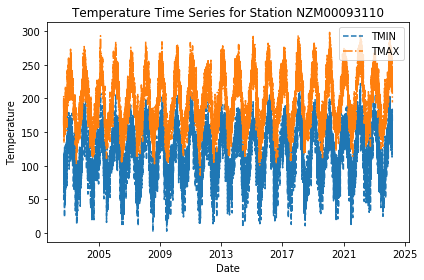

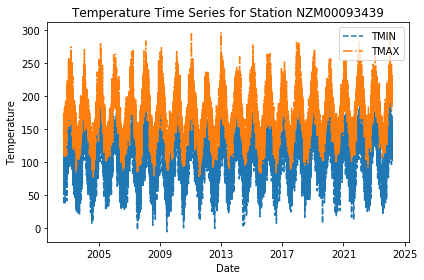

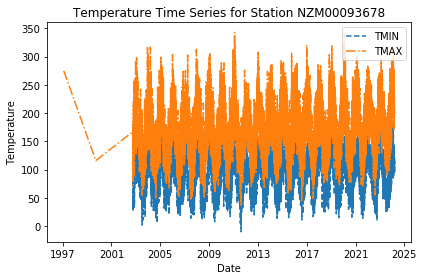

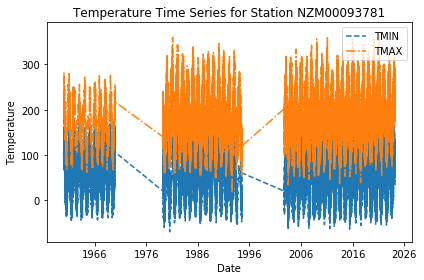

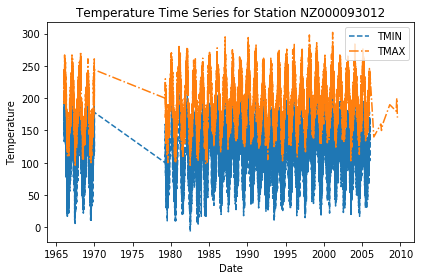

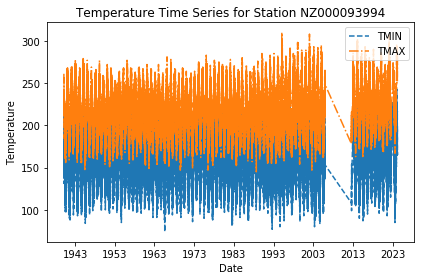

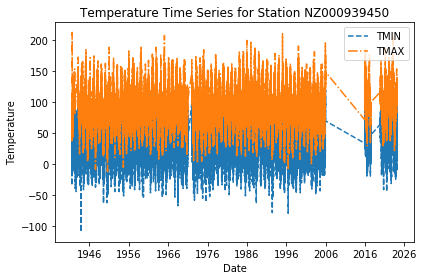

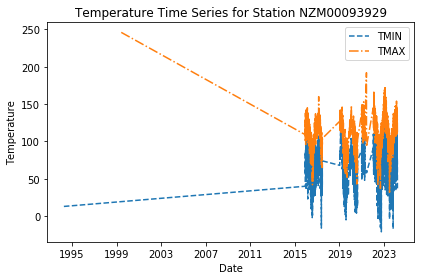

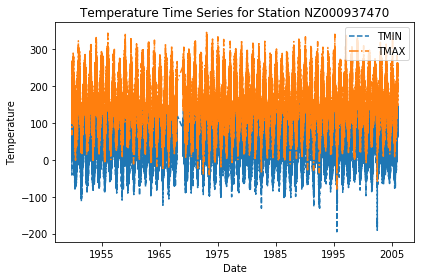

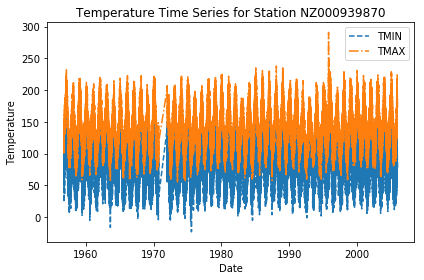

In [41]:
pandas_df = nz_tmin_tmax.toPandas()

pandas_df["DATE"] =pd.to_datetime(pandas_df["DATE"],format="%Y%m%d")

# plot time series for TMIN and TMAX for each station in NZ
for station in pandas_df["ID"].unique():
    station_data = pandas_df[pandas_df["ID"]==station]
    tmin = station_data[station_data["ELEMENT"]=="TMIN"].sort_values(by="DATE")
    tmax = station_data[station_data["ELEMENT"]=="TMAX"].sort_values(by="DATE")
    plt.plot(tmin["DATE"],tmin["VALUE"],label="TMIN",linestyle="--")
    plt.plot(tmax["DATE"],tmax["VALUE"],label="TMAX",linestyle="-.")
    
    plt.title(f"Temperature Time Series for Station {station}")
    plt.xlabel("Date")
    plt.ylabel("Temperature")
    plt.legend(loc="upper right",bbox_to_anchor=(1,1))
    plt.tight_layout()
    plt.show()

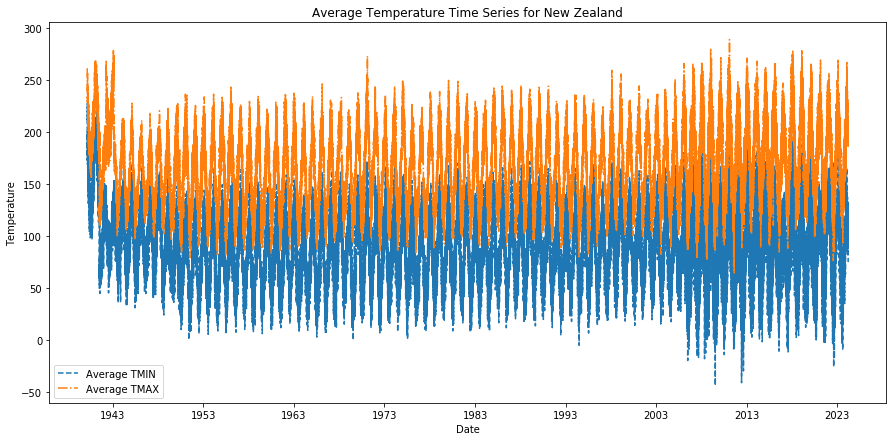

In [42]:
# get the average TMIN and TMAX
pandas_df['DATE'] = pd.to_datetime(pandas_df['DATE'], format='%Y%m%d')
avg_tmin = pandas_df[pandas_df['ELEMENT'] == 'TMIN'].groupby('DATE')['VALUE'].mean()
avg_tmax = pandas_df[pandas_df['ELEMENT'] == 'TMAX'].groupby('DATE')['VALUE'].mean()
# plot the average time series for TMIN and TMAX together for NZ
plt.figure(figsize=(15, 7))
plt.plot(avg_tmin.index, avg_tmin.values, label='Average TMIN', linestyle='--')
plt.plot(avg_tmax.index, avg_tmax.values, label='Average TMAX', linestyle='-.')
plt.legend()
plt.title('Average Temperature Time Series for New Zealand')
plt.xlabel('Date')
plt.ylabel('Temperature')

plt.show()

In [43]:
# First, let's add a year column and a country code column to df_all_daily
df_all_daily = df_all_daily.withColumn('YEAR', F.substring(df_all_daily["DATE"], 1, 4))
df_all_daily = df_all_daily.withColumn('COUNTRY_CODE', F.substring(df_all_daily["ID"], 1, 2))

# Filter for precipitation observations (PRCP is the element code for precipitation)
df_precipitation = df_all_daily.filter(df_all_daily["ELEMENT"] == 'PRCP')

# Group by year and country code, and calculate the average rainfall
df_avg_rainfall = df_precipitation.groupBy('YEAR', 'COUNTRY_CODE').agg(
    F.avg('VALUE').alias('AVERAGE_RAINFALL')
)
df_avg_rainfall.show()

+----+------------+------------------+
|YEAR|COUNTRY_CODE|  AVERAGE_RAINFALL|
+----+------------+------------------+
|2009|          BK|37.044673539518904|
|2009|          CW|35.091603053435115|
|2009|          GB|114.67282321899737|
|2009|          MC| 46.30769230769231|
|2009|          MZ| 67.22142121524202|
|2012|          CS| 89.51336898395722|
|2012|          MC| 33.76502732240437|
|2012|          JO|26.391304347826086|
|2012|          MJ|208.73181818181817|
|2012|          KG|17.555555555555557|
|2012|          AF| 35.42553191489362|
|2015|          BD| 40.00281690140845|
|2015|          BH| 51.92857142857143|
|2015|          CJ|29.497076023391813|
|2015|          HO| 33.44428468727534|
|2015|          KR| 67.05333333333333|
|2015|          RI|18.035616438356165|
|2015|          SN| 34.76164383561644|
|2015|          TX| 54.42553191489362|
|2015|          EG| 32.46762589928058|
+----+------------+------------------+
only showing top 20 rows



In [44]:
# Saving the result to the output directory
output_path5 = "hdfs:///user/dwe55/outputs/df_avg_rainfall"
df_avg_rainfall.write.mode("overwrite").csv(output_path5)

In [45]:
# Find the country with the highest average rainfall in a single year
windowSpec = Window.partitionBy("YEAR").orderBy(F.desc("AVERAGE_RAINFALL"))
df_max_rainfall_per_year = (df_avg_rainfall
                           .withColumn("RANK",F.rank().over(windowSpec))
                           .filter(F.col("RANK")==1)
                           .withColumn("AVERAGE_RAINFALL",F.format_number("AVERAGE_RAINFALL",2))
                           .drop("RANK")
                           .orderBy("YEAR"))
df_max_rainfall_per_year.show(300)

+----+------------+----------------+
|YEAR|COUNTRY_CODE|AVERAGE_RAINFALL|
+----+------------+----------------+
|1750|          AS|           30.78|
|1781|          GM|           24.56|
|1782|          GM|           13.71|
|1783|          GM|           17.83|
|1784|          GM|           16.58|
|1785|          GM|           16.17|
|1786|          GM|           24.17|
|1789|          GM|           18.48|
|1790|          GM|           15.50|
|1791|          GM|           17.48|
|1792|          GM|           18.12|
|1794|          GM|           20.75|
|1795|          GM|           14.49|
|1796|          GM|           14.44|
|1797|          GM|           15.95|
|1798|          GM|           16.66|
|1800|          GM|           16.02|
|1801|          GM|           19.42|
|1802|          GM|           12.33|
|1803|          GM|           19.63|
|1804|          GM|           17.43|
|1805|          GM|           16.10|
|1806|          EZ|           14.04|
|1807|          GM|           16.25|
|

In [46]:
# Plot the average rainfall in 2023 for each country
df_2023 = df_avg_rainfall.filter(df_avg_rainfall["YEAR"] == "2023")

# Collect the data into a Pandas DataFrame
# This requires a Spark action, e.g., .toPandas()
df_2023_pd= df_2023.toPandas()


In [ ]:
# save the dataset
output_path5 = "hdfs:///user/dwe55/outputs/df_2023_pd"
df_2023.write.mode("overwrite").csv(output_path5)

In [ ]:
# Run this cell before closing the notebook or kill your spark application by hand using the link in the Spark UI

stop_spark()